In [1]:
import numpy as np
import matplotlib.pyplot as plt

# get data
eeg_data = np.genfromtxt("data/reduced.txt", delimiter=" ").astype(np.float32)
eeg_data.shape

(24, 76800)

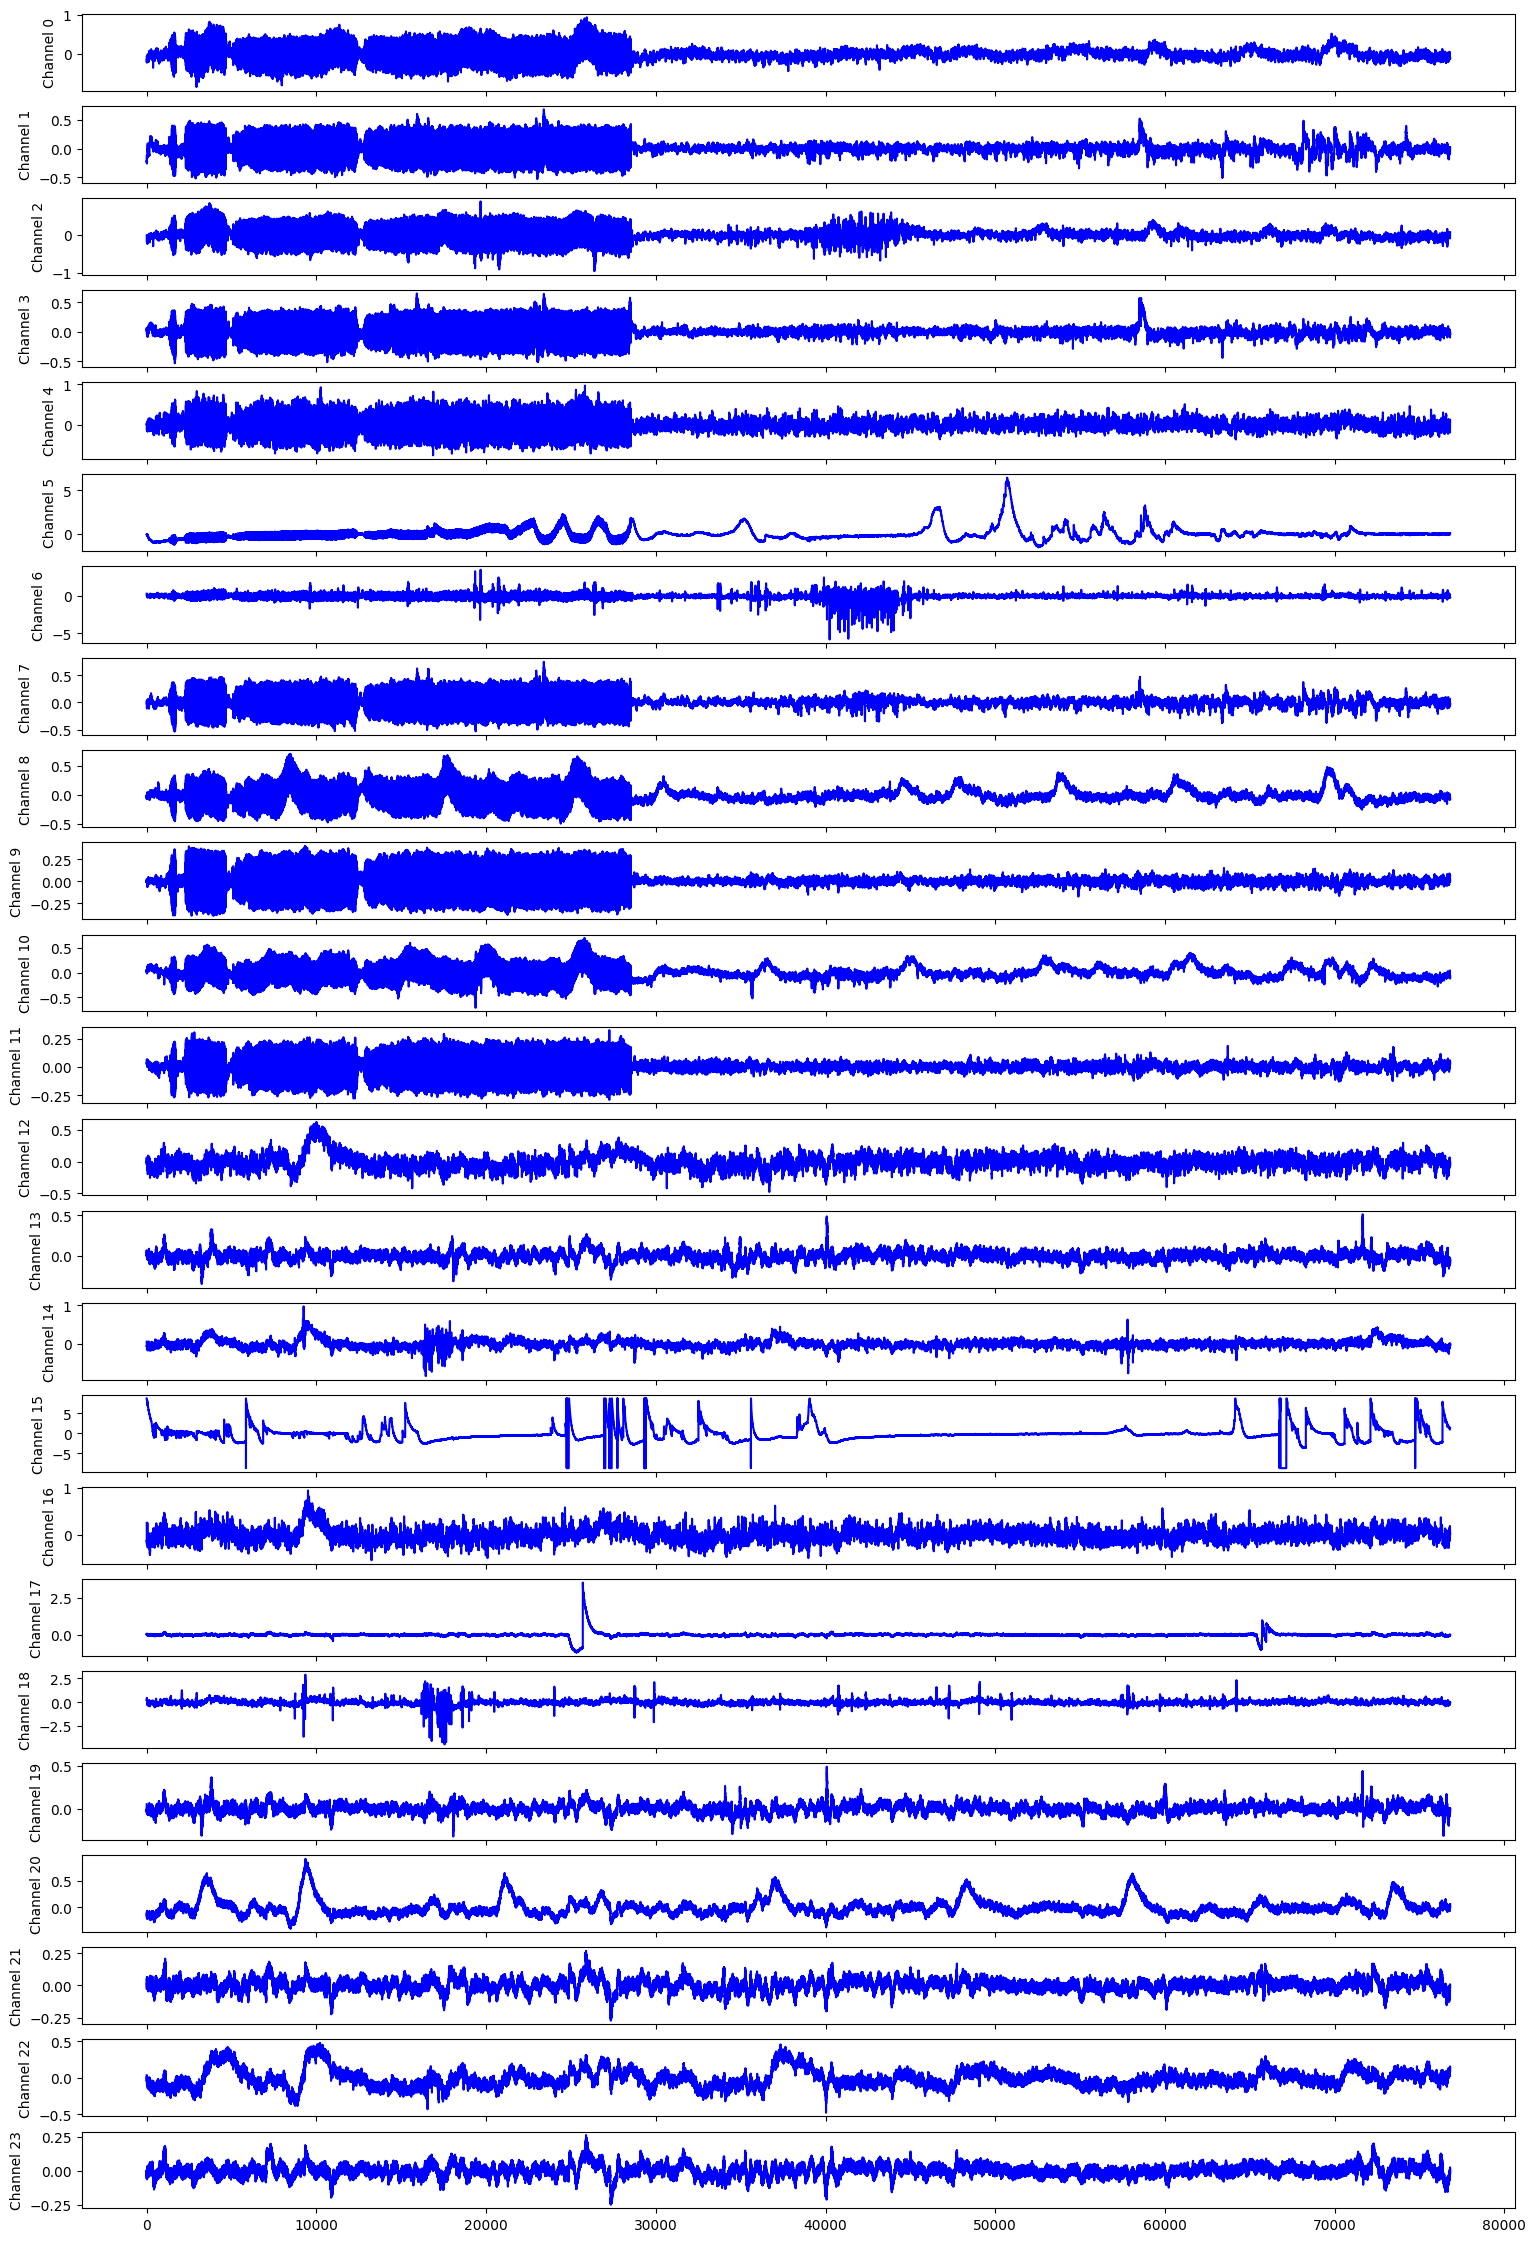

In [2]:
# visualize for good measure
time = [i for i in range(eeg_data.shape[1])]

fig, axs = plt.subplots(eeg_data.shape[0], 1, sharex=True)
fig.set_size_inches(18.5, 28.5)

for c in range(eeg_data.shape[0]):
    axs[c].plot(time, eeg_data[c], 'b')
    axs[c].set_ylabel(f"Channel {c}")

## State 1

Detected at `t=28928`.

In [3]:
from importlib import reload
import CPD.benchwarm

reload(CPD.benchwarm)

<module 'CPD.benchwarm' from 'c:\\Users\\saidmf\\Desktop\\Projects\\eeg-regime-change\\CPD\\benchwarm.py'>

In [4]:
# put arrays in dictionary for labels
channels = {}
for i in range(len(eeg_data)):
    channels[f"channel_{i}"] = eeg_data[i]

In [5]:
# warm up for 20 seconds and determine best lags
# (runs in 5 mins)
arpwarm = CPD.benchwarm.ARPWarm(channels, n0=20, chunks=6)
arpwarm.warmup()

['channel_0', 'channel_1', 'channel_2', 'channel_3']
channel_1: order AR(104)
channel_0: order AR(22)
channel_1: fitting complete
AIC:-11293.46836413405
Log-Likelihood:5752.734182067025
channel_1: innovations generated
Mean:5.876587671061497e-18
Std-dev:0.023254490838769567

channel_0: fitting complete
AIC:-10905.377784946291
Log-Likelihood:5476.688892473146
channel_0: innovations generated
Mean:6.351630542772763e-16
Std-dev:0.02796464130491734

channel_3: order AR(126)
channel_2: order AR(23)
channel_2: fitting complete
AIC:-11704.079985059363
Log-Likelihood:5877.0399925296815
channel_2: innovations generated
Mean:1.8728941666498797e-15
Std-dev:0.023861956500675935

channel_3: fitting complete
AIC:-11248.427285486958
Log-Likelihood:5752.213642743479
channel_3: innovations generated
Mean:-6.796352944500753e-18
Std-dev:0.022772207060437578

['channel_4', 'channel_5', 'channel_6', 'channel_7']
channel_4: order AR(20)
channel_4: fitting complete
AIC:-8535.362829874923
Log-Likelihood:4289.

In [6]:
import CPD.benchmark
reload(CPD.benchmark)

<module 'CPD.benchmark' from 'c:\\Users\\saidmf\\Desktop\\Projects\\eeg-regime-change\\CPD\\benchmark.py'>

In [116]:
cpd = CPD.benchmark.Online(arpwarm, k=5, M=18)

In [117]:
change_point, forecasts = cpd.run()

cpt = max(change_point.values())

print(f"change point detected at t={cpt}")

STEP 20
STEP 21
channel_23 rejection incremented 1
channel_22 rejection incremented 1
channel_19 rejection incremented 1
channel_14 rejection incremented 1
channel_13 rejection incremented 1
channel_17 rejection incremented 1
STEP 22
channel_23 rejection incremented 2
channel_22 rejection incremented 2
channel_5 rejection incremented 1
channel_19 resetting rejection
channel_14 rejection incremented 2
channel_13 resetting rejection
channel_17 resetting rejection
channel_12 rejection incremented 1
channel_15 rejection incremented 1
STEP 23
channel_23 resetting rejection
channel_22 resetting rejection
channel_5 rejection incremented 2
channel_20 rejection incremented 1
channel_14 resetting rejection
channel_12 rejection incremented 2
channel_15 resetting rejection
STEP 24
channel_5 rejection incremented 3
channel_20 rejection incremented 2
channel_12 rejection incremented 3
STEP 25
channel_5 rejection incremented 4
channel_19 rejection incremented 1
channel_20 rejection incremented 3
chan

In [118]:
change_point

{'channel_5': 5120,
 'channel_22': 5632,
 'channel_14': 10624,
 'channel_15': 18304,
 'channel_12': 28928}

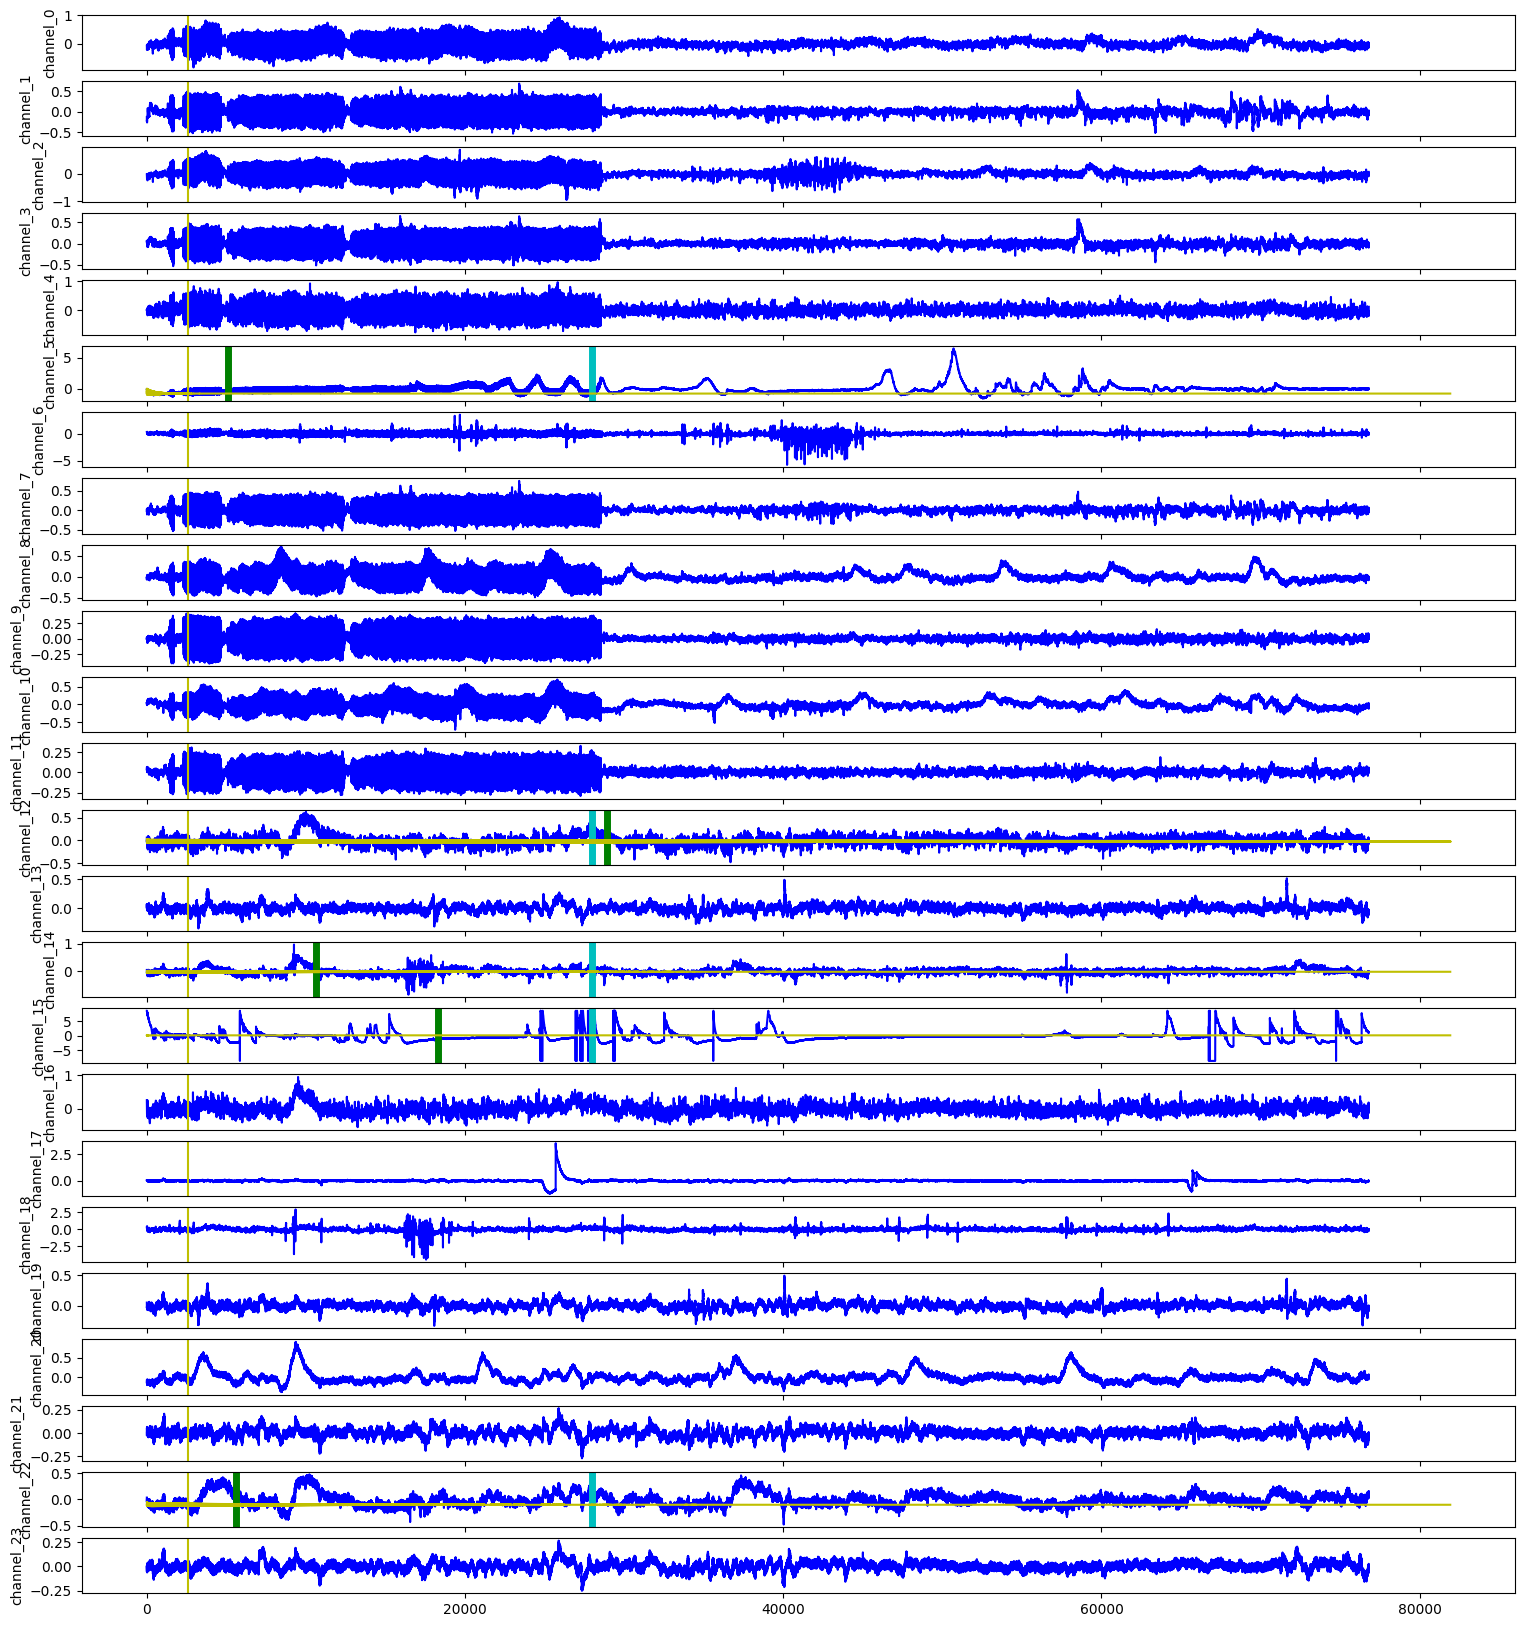

In [120]:
time = [i for i in range(eeg_data.shape[1])]

warmup = 20 * 128
actual_change = 28000

fig, axs = plt.subplots(eeg_data.shape[0], 1, sharex=True)
fig.set_size_inches(18.5, 20.5)

for c in range(eeg_data.shape[0]):
    chan = f"channel_{c}"
    axs[c].plot(time, channels[chan], 'b')
    
    axs[c].axvline(x=warmup, c='y')
    if chan in change_point:
        cpt = change_point[chan]
        axs[c].axvline(x=cpt, c='g', linewidth=5)
        axs[c].axvline(x=actual_change, c='c', linewidth=5)
        fore_time = [i for i in range(len(forecasts[chan]))]
        axs[c].plot(fore_time, forecasts[chan], 'y')
    axs[c].set_ylabel(chan)

## State 2

Detected at 

In [140]:
# get data past detected change-point `t=28928`

post_channels = {}
for i in range(len(eeg_data)):
    post_channels[f"channel_{i}"] = eeg_data[i][cpt:]

In [141]:
post_channels["channel_0"].shape

(47872,)

In [142]:
# warm up for 20 seconds and determine best lags
# (warms up in ~7 mins)

arpwarm2 = CPD.benchwarm.ARPWarm(post_channels, n0=20, chunks=6)
arpwarm2.warmup()

['channel_0', 'channel_1', 'channel_2', 'channel_3']
['channel_4', 'channel_5', 'channel_6', 'channel_7']
['channel_8', 'channel_9', 'channel_10', 'channel_11']
['channel_12', 'channel_13', 'channel_14', 'channel_15']
['channel_16', 'channel_17', 'channel_18', 'channel_19']
['channel_20', 'channel_21', 'channel_22', 'channel_23']


In [151]:
cpd2 = CPD.benchmark.Online(arpwarm2, k=5, M=12)

In [152]:
change_points2, forecasts2 = cpd2.run()

cpt2 = max(change_points2.values())

print(f"change point detected at t={cpt2}")

STEP 20
channel_7 rejection incremented 1
STEP 21
channel_23 rejection incremented 1
channel_22 rejection incremented 1
channel_5 rejection incremented 1
channel_7 resetting rejection
channel_20 rejection incremented 1
channel_13 rejection incremented 1
channel_17 rejection incremented 1
channel_21 rejection incremented 1
channel_12 rejection incremented 1
STEP 22
channel_23 resetting rejection
channel_22 resetting rejection
channel_5 rejection incremented 2
channel_20 rejection incremented 2
channel_13 resetting rejection
channel_17 resetting rejection
channel_21 resetting rejection
channel_12 resetting rejection
STEP 23
channel_0 rejection incremented 1
channel_5 rejection incremented 3
channel_20 rejection incremented 3
STEP 24
channel_0 resetting rejection
channel_5 resetting rejection
channel_7 rejection incremented 1
channel_20 rejection incremented 4
channel_1 rejection incremented 1
STEP 25
channel_0 rejection incremented 1
channel_7 rejection incremented 2
channel_20 resetting

27072


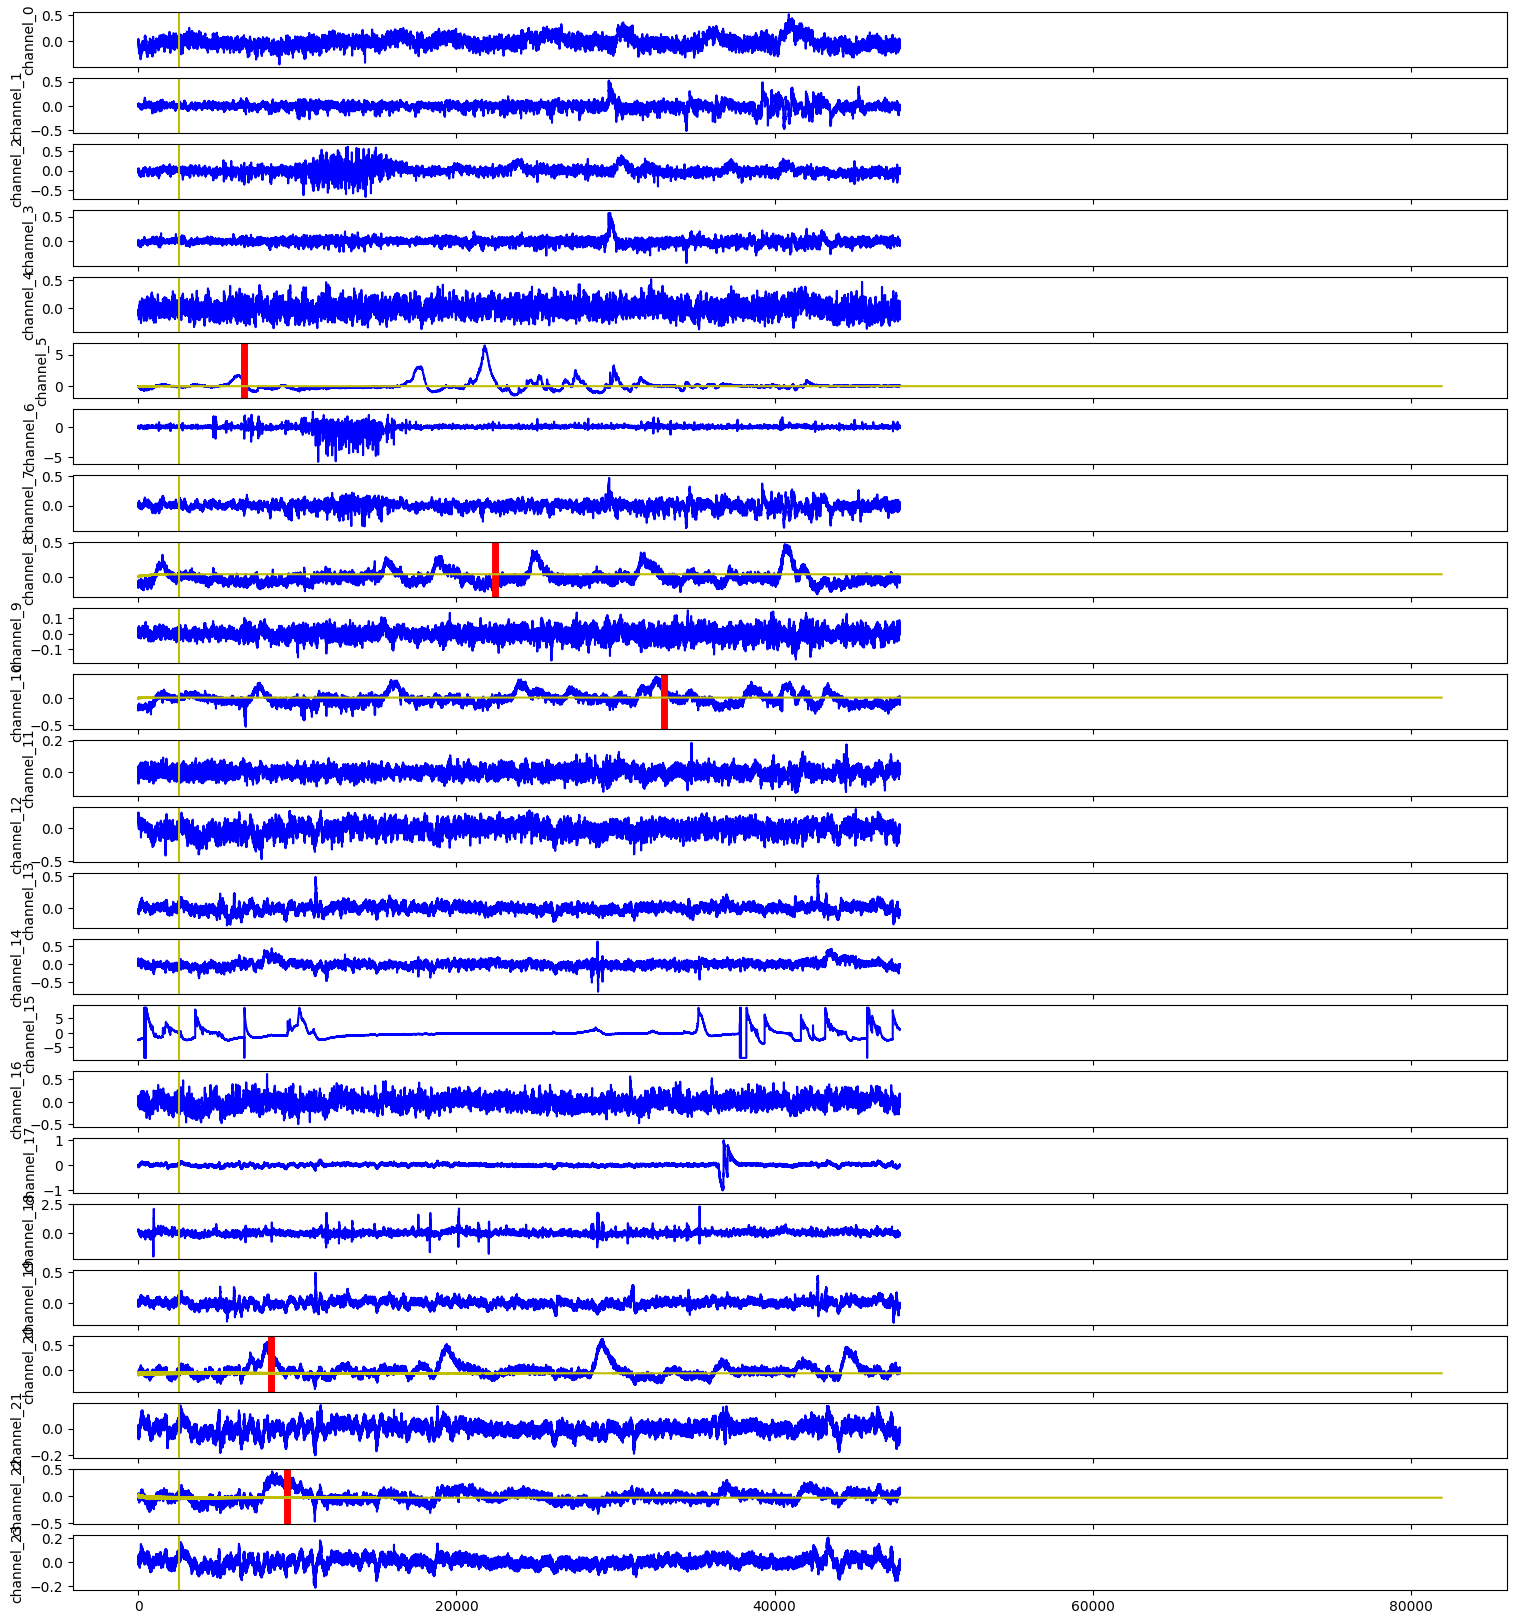

In [154]:
warmup = 20 * 128
# actual_change = 50000 - (cpt - 28000)

time = [i for i in range(post_channels["channel_0"].shape[0])]

fig, axs = plt.subplots(len(post_channels), 1, sharex=True)
fig.set_size_inches(18.5, 20.5)

for c in range(eeg_data.shape[0]):
    chan = f"channel_{c}"
    axs[c].plot(time, post_channels[chan], 'b')

    axs[c].axvline(x=warmup, c='y')

    if chan in change_points2:
        next_cpt = change_points2[chan]
        axs[c].axvline(x=next_cpt, c='r', linewidth=5)
        # axs[c].axvline(x=actual_change, c='m', linewidth=5)
        fore_time = [i for i in range(len(forecasts2[chan]))]
        axs[c].plot(fore_time, forecasts2[chan], 'y')

    axs[c].set_ylabel(chan)

print(actual_change)